In [1]:
# 패키지 불러오기
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as tsa
import plotly.graph_objs as go
import datetime
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
excelFile = 'C:/Users/chunc/Desktop/데이터 샘플/파이널프로젝트 데이터/data_cat_all.xlsx'
df = pd.read_excel(excelFile)
df.head()

,period,디지털/가전,패션의류,가구/인테리어,도서,생활/건강,스포츠/레저,식품,출산/육아,패션잡화,화장품/미용
0,2021-05-10,12.18344,9.68679,5.44947,0.04328,13.94238,7.33006,6.43235,5.15469,10.05799,3.29609
1,2021-05-11,11.39762,9.55987,4.97732,0.10491,13.29577,6.87210,6.27344,4.86485,9.78046,3.15404
2,2021-05-12,11.31013,9.80653,4.82853,0.11601,12.95931,6.64342,5.94068,4.88141,9.74198,3.03323
3,2021-05-13,11.18911,9.89209,4.56359,0.10808,12.32444,6.36751,5.60075,4.93127,9.43991,2.88430
4,2021-05-14,10.88907,9.44241,4.24099,0.09742,11.44237,5.80616,5.05788,4.62662,8.98145,2.70522


In [3]:
# period컬럼의 데이터타입 변경
df['period'] = pd.to_datetime(df['period'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785 entries, 0 to 784
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   period   785 non-null    datetime64[ns]
 1   디지털/가전   785 non-null    float64       
 2   패션의류     785 non-null    float64       
 3   가구/인테리어  785 non-null    float64       
 4   도서       785 non-null    float64       
 5   생활/건강    785 non-null    float64       
 6   스포츠/레저   785 non-null    float64       
 7   식품       785 non-null    float64       
 8   출산/육아    785 non-null    float64       
 9   패션잡화     785 non-null    float64       
 10  화장품/미용   785 non-null    float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 67.6 KB


In [4]:
# 디지털/가전 항목의 시계열 데이터 프레임 생성
# ts_df1 = pd.pivot_table(data = df, index = 'period', values = '디지털/가전').reset_index()
# ts_df1.set_index('period')
timeSeries = df.loc[:, ['period', '디지털/가전']]
timeSeries.index = timeSeries.period
ts = timeSeries.drop('period', axis = 1)

D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\pythonEx\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2023-01-28     68.942257
2023-01-29     68.603318
2023-01-30     68.671494
2023-01-31     69.025229
2023-02-01     69.475706
                 ...    
2023-06-29    126.511020
2023-06-30    126.895911
2023-07-01    127.280802
2023-07-02    127.665693
2023-07-03    128.050584
Freq: D, Name: predicted_mean, Length: 157, dtype: float64
            lower 디지털/가전  upper 디지털/가전
2023-01-28     66.283716     71.600798
2023-01-29     64.605168     72.601468
2023-01-30     63.955938     73.387050
2023-01-31     63.876902     74.173556
2023-02-01     63.988777     74.962634
...                  ...           ...
2023-06-29     73.581620    179.440421
2023-06-30     73.590693    180.201130
2023-07-01     73.598953    180.962651
2023-07-02     73.606403    181.724984
2023-07-03     73.613042    182.488126

[157 rows x 2 columns]


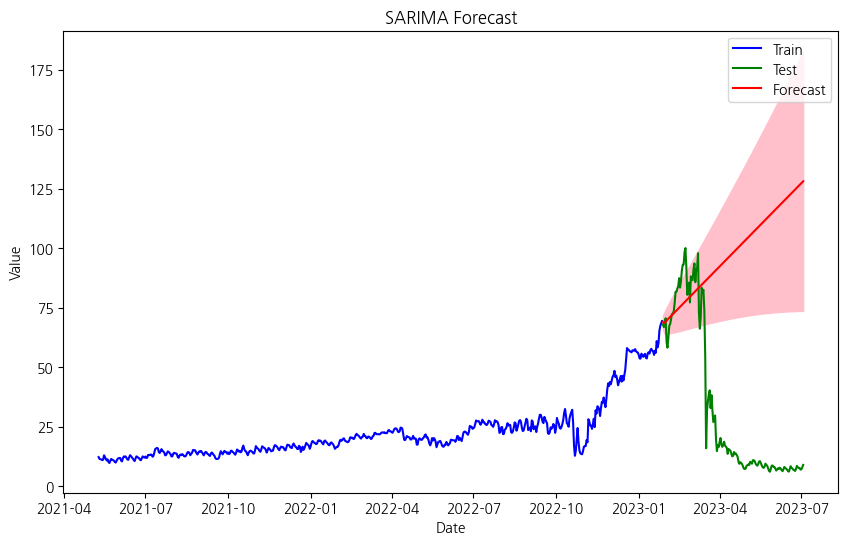

In [5]:
# 데이터 분할 (train/test)
# 예시로 80%를 train 데이터로, 나머지 20%를 test 데이터로 분할합니다.
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

# Step 1: auto_arima를 사용하여 최적의 SARIMA 모델 찾기 (계절성 고려)
model_fit = auto_arima(train, seasonal=True, m=1, suppress_warnings=True, stepwise=True)
order = model_fit.order
seasonal_order = model_fit.seasonal_order

# Step 2: 최적 모델로 SARIMAX 모델 구성
sarima_model = SARIMAX(train, order=order, seasonal_order=seasonal_order)

# 모델 피팅
results = sarima_model.fit(disp=False)

# 1. get_prediction -> 구간을 설정하여 예측
# test 데이터 기간으로 예측
forecast = results.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)

# 예측값과 신뢰구간(lower, upper) 출력
print(forecast.predicted_mean)
print(forecast.conf_int())

# 결과 시각화
plt.figure(figsize=(10, 6))
# train 데이터 플롯
plt.plot(train, label='Train', color='blue')
# test 데이터 플롯
plt.plot(test, label='Test', color='green')
# 예측값 플롯
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
# 신뢰구간 플롯
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower 디지털/가전'], forecast.conf_int()['upper 디지털/가전'], color='pink')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [8]:
import numpy as np
from sklearn.metrics import mean_squared_error

# 단계 1: SARIMA 모델에서 예측된 값을 계산합니다.
forecasted_values = forecast.predicted_mean

# 단계 2: 테스트 데이터셋에서 실제 값들을 추출합니다.
actual_values = test['디지털/가전']

# 단계 3: 예측된 값과 실제 값 사이의 제곱 오차를 계산합니다.
squared_errors = (forecasted_values - actual_values) ** 2

# 단계 4: 평균 제곱 오차(MSE)를 계산합니다.
mse = np.mean(squared_errors)

# 단계 5: 제곱근 평균 제곱 오차(RMSE)를 계산합니다.
rmse = np.sqrt(mse)

print("평균 제곱 오차(MSE):", mse)
print("제곱근 평균 제곱 오차(RMSE):", rmse)

평균 제곱 오차(MSE): 6542.309525102097
제곱근 평균 제곱 오차(RMSE): 80.88454441425813
